## Document Classification (RVL-CDIP - Validation Subset Only)

Dataset Source: https://www.kaggle.com/datasets/achrafbribiche/document-classification

#### Import Necessary Libraries

In [1]:
import os, sys, glob

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import PIL.Image

import transformers
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import datasets
from datasets import load_dataset, Features, Array3D, DatasetDict, ClassLabel

import torch
from torch import nn

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Languages & Libraries

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("evaluate:".rjust(15), evaluate.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.24.3
      Datasets: 2.11.0
  Transformers: 4.28.1
      evaluate: 0.4.0
         Torch: 2.0.0


#### Converting Labels Between String & Integer Values

In [3]:
labels = ["receipt",
          "other",
          "invoice",
          ]

NUM_OF_LABELS = len(labels)

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(labels)
print(NUM_OF_LABELS)
print(id2label)
print(label2id)

['receipt', 'other', 'invoice']
3
{0: 'receipt', 1: 'other', 2: 'invoice'}
{'receipt': 0, 'other': 1, 'invoice': 2}


#### Prepare Dataset for Project

In [4]:
parent_dir = "/Users/briandunn/Desktop/Document Classification/Doc CLF/data"

dir_path = os.path.join(parent_dir, "*", "*")

files_and_name = glob.glob(dir_path)

metadata = pd.DataFrame(files_and_name, columns=["file_path"])

metadata['file_name'] = metadata['file_path'].apply(lambda x: x.split("/")[-2] + "/" + x.split("/")[-1])

metadata['label'] = metadata['file_path'].apply(lambda x: x.split("/")[-2])

metadata = metadata.drop(columns=["file_path"])

metadata['label'] = metadata['label'].replace(label2id)

metadata_file_location = os.path.join(parent_dir, "metadata.csv")
metadata.to_csv(metadata_file_location, index=False)

metadata.tail()

,file_name,label
40350,invoice/0001219662.tif,2
40351,invoice/CTRCONTRACTS000674-0.tif,2
40352,invoice/2040735344.tif,2
40353,invoice/80704452.tif,2
40354,invoice/513269908_513269911.tif,2


#### Ingest Dataset

In [5]:
dataset = load_dataset(parent_dir)

dataset = dataset.cast_column("label", ClassLabel(names=[0, 1, 2]))

dataset

Resolving data files:   0%|          | 0/40356 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/briandunn/.cache/huggingface/datasets/imagefolder/data-f976cea635e6b676/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Casting the dataset:   0%|          | 0/40355 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 40355
    })
})

#### Display Example of Sample 

In [6]:
dataset['train'][10]

{'image': <PIL.TiffImagePlugin.TiffImageFile image mode=L size=762x1000>,
 'label': 2}

#### Split Dataset into Training & Evaluation Datasets

In [7]:
train_split = dataset['train'].train_test_split(train_size=0.66)

ds = DatasetDict({
    'train' : train_split['train'],
    'eval' : train_split['test']
})

#### Show Some Information About Training & Testing Datasets

In [8]:
print("Training Dataset")
print(ds['train'])
print("Features: ", ds['train'].features)
print("First Entry:", ds['train'][0])
print("Last Entry:", ds['train'][-1])
print("Unique Label Values:", sorted(ds['train'].unique("label")))

print("\nEvaluation Dataset")
print(ds['eval'])
print("Features: ", ds['eval'].features)
print("First Entry:", ds['eval'][0])
print("Last Entry:", ds['eval'][-1])
print("Unique Label Values:", sorted(ds['eval'].unique("label")))

Training Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 26634
})
Features:  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=[0, 1, 2], id=None)}
First Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=747x1219 at 0x7F77C84E9370>, 'label': 0}
Last Entry: {'image': <PIL.TiffImagePlugin.TiffImageFile image mode=L size=776x1000 at 0x7F77B9842670>, 'label': 1}


Flattening the indices:   0%|          | 0/26634 [00:00<?, ? examples/s]

Unique Label Values: [0, 1, 2]

Evaluation Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 13721
})
Features:  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=[0, 1, 2], id=None)}
First Entry: {'image': <PIL.TiffImagePlugin.TiffImageFile image mode=L size=762x1000 at 0x7F77C84FD760>, 'label': 1}
Last Entry: {'image': <PIL.TiffImagePlugin.TiffImageFile image mode=L size=754x1000 at 0x7F77B9842F10>, 'label': 1}


Flattening the indices:   0%|          | 0/13721 [00:00<?, ? examples/s]

Unique Label Values: [0, 1, 2]


#### Display Example Document

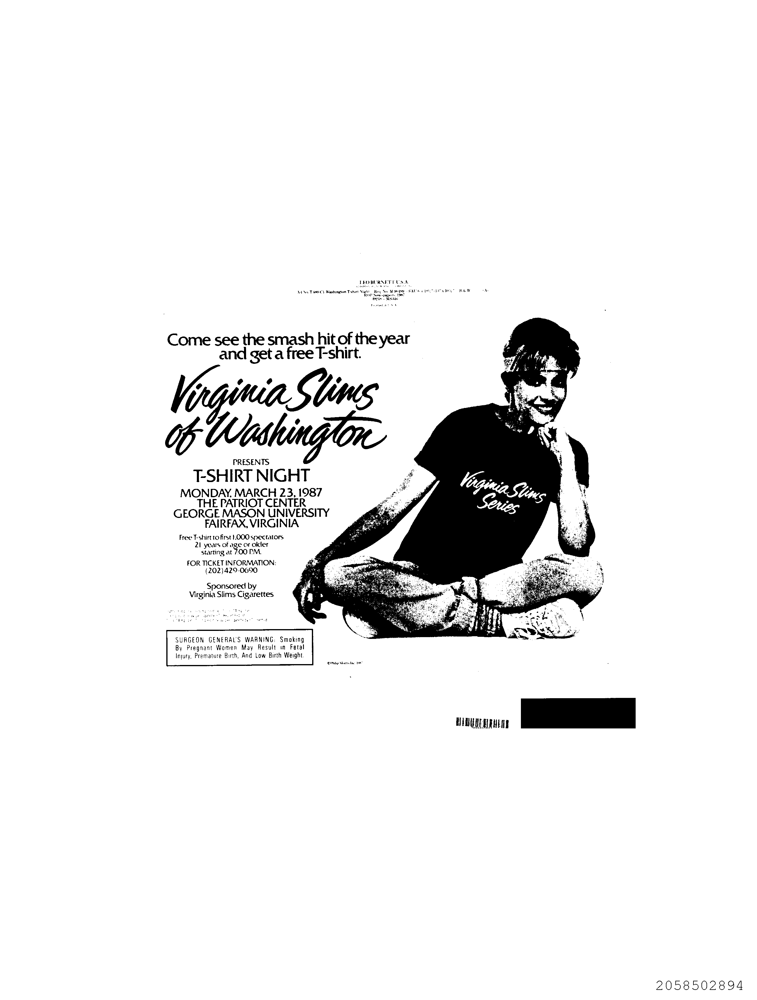

In [9]:
ds['train'][2]['image']

#### Show Class of Example

In [10]:
class_label_number = ds['train'][2]['label']
print(class_label_number)

1


#### Class Name for Example

In [11]:
label_names = dataset['train'].features['label'].names
print(id2label[class_label_number])

other


#### Basic Values/Constants

In [12]:
MODEL_CKPT = "microsoft/dit-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Document_Classification-RVL_CDIP"

NUM_OF_EPOCHS = 3
LEARNING_RATE = 5e-5

BATCH_SIZE = 32
DEVICE = torch.device("cpu") 

REPORTS_TO = 'tensorboard'
STRATEGY = "epoch"

#### Instantiate Feature Extractor

In [13]:
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CKPT)
feature_extractor

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/models/beit/image_processing_beit.py:108: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


BeitFeatureExtractor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

#### Create Functions to Transform Datasets for Training & Evaluation

In [14]:
# normalize
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# train_transforms
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),# it was a list that used [], not ()
            RandomHorizontalFlip(),
            ToTensor(),
            normalize
        ]
    )

# eval_transforms
val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """
    Apply train_transforms across a batch
    """
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """
    Apply val_transforms across a batch
    """
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

#### Apply Preprocessing Functions to Appropriate Datasets

In [15]:
ds['train'].set_transform(preprocess_train)
ds['eval'].set_transform(preprocess_val)

#### Display Example of Preprocessed Document

In [16]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=747x1219>,
 'label': 0,
 'pixel_values': tensor([[[0.6863, 0.6941, 0.6941,  ..., 0.6863, 0.6784, 0.6863],
          [0.6941, 0.6863, 0.6784,  ..., 0.6784, 0.6784, 0.6706],
          [0.6784, 0.6627, 0.6706,  ..., 0.6784, 0.6863, 0.6863],
          ...,
          [0.5216, 0.5294, 0.5451,  ..., 0.5529, 0.5529, 0.5451],
          [0.5294, 0.5451, 0.5294,  ..., 0.5373, 0.5294, 0.5294],
          [0.5451, 0.5294, 0.5137,  ..., 0.5294, 0.5137, 0.5137]],
 
         [[0.6863, 0.6941, 0.6941,  ..., 0.6863, 0.6784, 0.6863],
          [0.6941, 0.6863, 0.6784,  ..., 0.6784, 0.6784, 0.6706],
          [0.6784, 0.6627, 0.6706,  ..., 0.6784, 0.6863, 0.6863],
          ...,
          [0.5216, 0.5294, 0.5451,  ..., 0.5529, 0.5529, 0.5451],
          [0.5294, 0.5451, 0.5294,  ..., 0.5373, 0.5294, 0.5294],
          [0.5451, 0.5294, 0.5137,  ..., 0.5294, 0.5137, 0.5137]],
 
         [[0.6863, 0.6941, 0.6941,  ..., 0.6863, 0.6784, 0.6863],
 

#### Instantiate Model

In [17]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Some weights of the model checkpoint at microsoft/dit-base were not used when initializing BeitForImageClassification: ['lm_head.weight', 'layernorm.bias', 'lm_head.bias', 'layernorm.weight']
- This IS expected if you are initializing BeitForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['classifier.bias', 'beit.pooler.layernorm.bias', 'classifier.weight', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

#### Define Training Arguments

In [18]:
args = TrainingArguments(
    MODEL_NAME,
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy="steps",
    logging_steps=12,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    num_train_epochs=NUM_OF_EPOCHS,
    warmup_ratio=0.10,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Function to Compute Metrics

In [19]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]

    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']

    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]

    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]

    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
                                                  
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]

    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define Data Collation Function

In [20]:
def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#### Subclass Trainer to Handle Class Imbalance

In [21]:
class CustomTrainer(Trainer):
    def compute_loss(self, 
                     model, 
                     inputs, 
                     return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(
            [
                1.0, 2.0, 3.0
            ], 
            device=model.device))
        loss = loss_fct(logits.view(-1, 
                                    self.model.config.num_labels
                                    ), 
                        labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [22]:
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=ds['train'], 
    eval_dataset=ds['eval'], 
    tokenizer=feature_extractor, 
    compute_metrics=compute_metrics, 
    data_collator=collate_fn
)

Cloning https://huggingface.co/DunnBC22/dit-base-Document_Classification-RVL_CDIP into local empty directory.


#### Train Model & Save/Log Relevant Metrics

In [23]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/624 [00:00<?, ?it/s]

{'loss': 1.0855, 'learning_rate': 7.936507936507937e-07, 'epoch': 0.0}
{'loss': 0.9105, 'learning_rate': 9.523809523809523e-06, 'epoch': 0.06}
{'loss': 0.4616, 'learning_rate': 1.9047619047619046e-05, 'epoch': 0.12}
{'loss': 0.3415, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.17}
{'loss': 0.2655, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.23}
{'loss': 0.265, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.29}
{'loss': 0.2216, 'learning_rate': 4.919786096256685e-05, 'epoch': 0.35}
{'loss': 0.2317, 'learning_rate': 4.8128342245989304e-05, 'epoch': 0.4}
{'loss': 0.194, 'learning_rate': 4.705882352941177e-05, 'epoch': 0.46}
{'loss': 0.1895, 'learning_rate': 4.598930481283423e-05, 'epoch': 0.52}
{'loss': 0.1928, 'learning_rate': 4.491978609625669e-05, 'epoch': 0.58}
{'loss': 0.1852, 'learning_rate': 4.385026737967914e-05, 'epoch': 0.63}
{'loss': 0.1881, 'learning_rate': 4.2780748663101606e-05, 'epoch': 0.69}
{'loss': 0.1763, 'learning_rate': 4.171122994652407e-05, 'epoch':

  0%|          | 0/429 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.11255443841218948, 'eval_accuracy': 0.9622476495882224, 'eval_Weighted F1': 0.9596774503435738, 'eval_Micro F1': 0.9622476495882223, 'eval_Macro F1': 0.571105133243632, 'eval_Weighted Recall': 0.9622476495882224, 'eval_Micro Recall': 0.9622476495882224, 'eval_Macro Recall': 0.5924688273721617, 'eval_Weighted Precision': 0.9577464168056835, 'eval_Micro Precision': 0.9622476495882224, 'eval_Macro Precision': 0.5530940794496672, 'eval_runtime': 2995.4719, 'eval_samples_per_second': 4.581, 'eval_steps_per_second': 0.143, 'epoch': 1.0}
{'loss': 0.1777, 'learning_rate': 3.6363636363636364e-05, 'epoch': 1.04}
{'loss': 0.1577, 'learning_rate': 3.529411764705883e-05, 'epoch': 1.09}
{'loss': 0.1372, 'learning_rate': 3.4224598930481284e-05, 'epoch': 1.15}
{'loss': 0.1446, 'learning_rate': 3.3155080213903747e-05, 'epoch': 1.21}
{'loss': 0.1367, 'learning_rate': 3.20855614973262e-05, 'epoch': 1.27}
{'loss': 0.1283, 'learning_rate': 3.1016042780748666e-05, 'epoch': 1.33}
{'loss': 0.1

  0%|          | 0/429 [00:00<?, ?it/s]

{'eval_loss': 0.08434688299894333, 'eval_accuracy': 0.973835726259019, 'eval_Weighted F1': 0.9735756522364626, 'eval_Micro F1': 0.973835726259019, 'eval_Macro F1': 0.8501706517182783, 'eval_Weighted Recall': 0.973835726259019, 'eval_Micro Recall': 0.973835726259019, 'eval_Macro Recall': 0.8036955912090624, 'eval_Weighted Precision': 0.9741111567981213, 'eval_Micro Precision': 0.973835726259019, 'eval_Macro Precision': 0.9287080582761646, 'eval_runtime': 2834.0055, 'eval_samples_per_second': 4.842, 'eval_steps_per_second': 0.151, 'epoch': 2.0}
{'loss': 0.1102, 'learning_rate': 1.8181818181818182e-05, 'epoch': 2.02}
{'loss': 0.1248, 'learning_rate': 1.7112299465240642e-05, 'epoch': 2.07}
{'loss': 0.108, 'learning_rate': 1.60427807486631e-05, 'epoch': 2.13}
{'loss': 0.118, 'learning_rate': 1.4973262032085561e-05, 'epoch': 2.19}
{'loss': 0.1131, 'learning_rate': 1.3903743315508022e-05, 'epoch': 2.25}
{'loss': 0.1177, 'learning_rate': 1.2834224598930484e-05, 'epoch': 2.3}
{'loss': 0.1409, '

  0%|          | 0/429 [00:00<?, ?it/s]

{'eval_loss': 0.07859531044960022, 'eval_accuracy': 0.976678084687705, 'eval_Weighted F1': 0.9768442651021538, 'eval_Micro F1': 0.976678084687705, 'eval_Macro F1': 0.9154020288755031, 'eval_Weighted Recall': 0.976678084687705, 'eval_Micro Recall': 0.976678084687705, 'eval_Macro Recall': 0.9019139504496776, 'eval_Weighted Precision': 0.9771017843393915, 'eval_Micro Precision': 0.976678084687705, 'eval_Macro Precision': 0.9314436651998532, 'eval_runtime': 3028.7856, 'eval_samples_per_second': 4.53, 'eval_steps_per_second': 0.142, 'epoch': 3.0}
{'train_runtime': 60970.1196, 'train_samples_per_second': 1.311, 'train_steps_per_second': 0.01, 'train_loss': 0.17273353269466987, 'epoch': 3.0}


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Jul05_19-07-01_Brians-Mac-mini/events.out.tfevents.1688602026.Brians-Mac-mini.1301.0:   0%|  …

To https://huggingface.co/DunnBC22/dit-base-Document_Classification-RVL_CDIP
   2ad8c45..2f25c63  main -> main

To https://huggingface.co/DunnBC22/dit-base-Document_Classification-RVL_CDIP
   2f25c63..6197718  main -> main



***** train metrics *****
  epoch                    =         3.0
  train_loss               =      0.1727
  train_runtime            = 16:56:10.11
  train_samples_per_second =       1.311
  train_steps_per_second   =        0.01


#### Push Model to Hub (My Profile!!!)

In [24]:
trainer.push_to_hub()

To https://huggingface.co/DunnBC22/dit-base-Document_Classification-RVL_CDIP
   6197718..2828de2  main -> main



'https://huggingface.co/DunnBC22/dit-base-Document_Classification-RVL_CDIP/commit/2828de2510cba12c3a1824e2d031d2d8b7a30674'

### Notes & Other Takeaways From This Project
****
- While the results look respectable, there is an imblance in predictions. Most likely, the model struggled to accurately predict underrepresented class.

****

### Citations

- Model Checkpoint:
    > @misc{li2022dit, title={DiT: Self-supervised Pre-training for Document Image Transformer}, author={Junlong Li and Yiheng Xu and Tengchao Lv and Lei Cui and Cha Zhang and Furu Wei}, year={2022}, eprint={2203.02378}, archivePrefix={arXiv}, primaryClass={cs.CV}}

- Dataset
    > @inproceedings{harley2015icdar, title = {Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval}, author = {Adam W Harley and Alex Ufkes and Konstantinos G Derpanis}, booktitle = {International Conference on Document Analysis and Recognition ({ICDAR})}}, year = {2015}}